In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler

from catboost import CatBoostClassifier, Pool

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

###  Загрузка обучающего и тестового датасетов

In [2]:
data_train = pd.read_csv('content/train_dataset_train.csv')
data_test = pd.read_csv('content/test_dataset_test.csv')

In [3]:
id_test = data_test['id']

In [4]:
data_train.head(3)

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label
0,6818780,1043_-1,628629.0,Участок,7503.0,N,0.0,Y,N,87.0,...,42.0,720176.0,58950.0,779126.0,8290896.0,0,0,0,0,0
1,9907176,1023_-1,102976.0,ММПО,7503.0,N,0.0,N,N,107.0,...,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,0,0,0,0
2,3304275,1018_-1,620962.0,Цех,7503.0,N,0.0,Y,N,50.0,...,62.0,3246292.0,3233068.0,6479360.0,52708071.0,0,1,0,0,0


In [5]:
data_train.dtypes

id                                 int64
oper_type + oper_attr             object
index_oper                        object
type                              object
priority                         float64
is_privatecategory                object
class                            float64
is_in_yandex                      object
is_return                         object
weight                           float64
mailtype                         float64
mailctg                          float64
mailrank                         float64
directctg                        float64
transport_pay                    float64
postmark                         float64
name_mfi                          object
weight_mfi                       float64
price_mfi                        float64
dist_qty_oper_login_1            float64
total_qty_oper_login_1           float64
total_qty_oper_login_0           float64
total_qty_over_index_and_type    float64
total_qty_over_index             float64
is_wrong_sndr_na

# Очистка и предобработка данных / *Data cleaning and preprocessing*
### Посмотрим на распределение переменных и приведем переменные к рациональному формату

##### *Тип и атрибут операции*

In [6]:
data_train['oper_type + oper_attr'].value_counts().head(7)

1020_-1    693154
1022_-1    656597
1019_-1    413710
8_0        402877
1_-1       359402
1001_-1    353113
1018_-1    317883
Name: oper_type + oper_attr, dtype: int64

In [8]:
data_train[['oper_type', 'oper_attr']] = pd.DataFrame(data_train['oper_type + oper_attr'].str.split('_').tolist(), 
                                                   index=data_train.index).astype(int)
data_test[['oper_type', 'oper_attr']] = pd.DataFrame(data_test['oper_type + oper_attr'].str.split('_').tolist(), 
                                                   index=data_test.index).astype(int)

In [9]:
data_train = data_train.drop('oper_type + oper_attr', axis=1)
data_test = data_test.drop('oper_type + oper_attr', axis=1)

##### *Индекс места операции*

In [10]:
data_train['index_oper'].value_counts().head(7)

102976      938416
102976.0    661191
102971      476859
102971.0    341402
620984       80811
102998       63778
102968       58374
Name: index_oper, dtype: int64

In [11]:
data_train['index_oper'].value_counts().count()

38661

In [12]:
data_train['index_oper'] = np.where(data_train['index_oper'] == ' ', 0, data_train['index_oper'])
data_train['index_oper'] = pd.to_numeric(data_train['index_oper']).astype(int)

data_test['index_oper'] = np.where(data_test['index_oper'] == ' ', 0, data_test['index_oper'])
data_test['index_oper'] = pd.to_numeric(data_test['index_oper']).astype(int)

##### *Обозначение типа объекта почтовой связи*

In [13]:
data_train['type'] = np.where(data_train['type'] == '0', "ПРОЧЕЕ", data_train['type'])
data_test['type'] = np.where(data_test['type'] == '0', "ПРОЧЕЕ", data_test['type'])

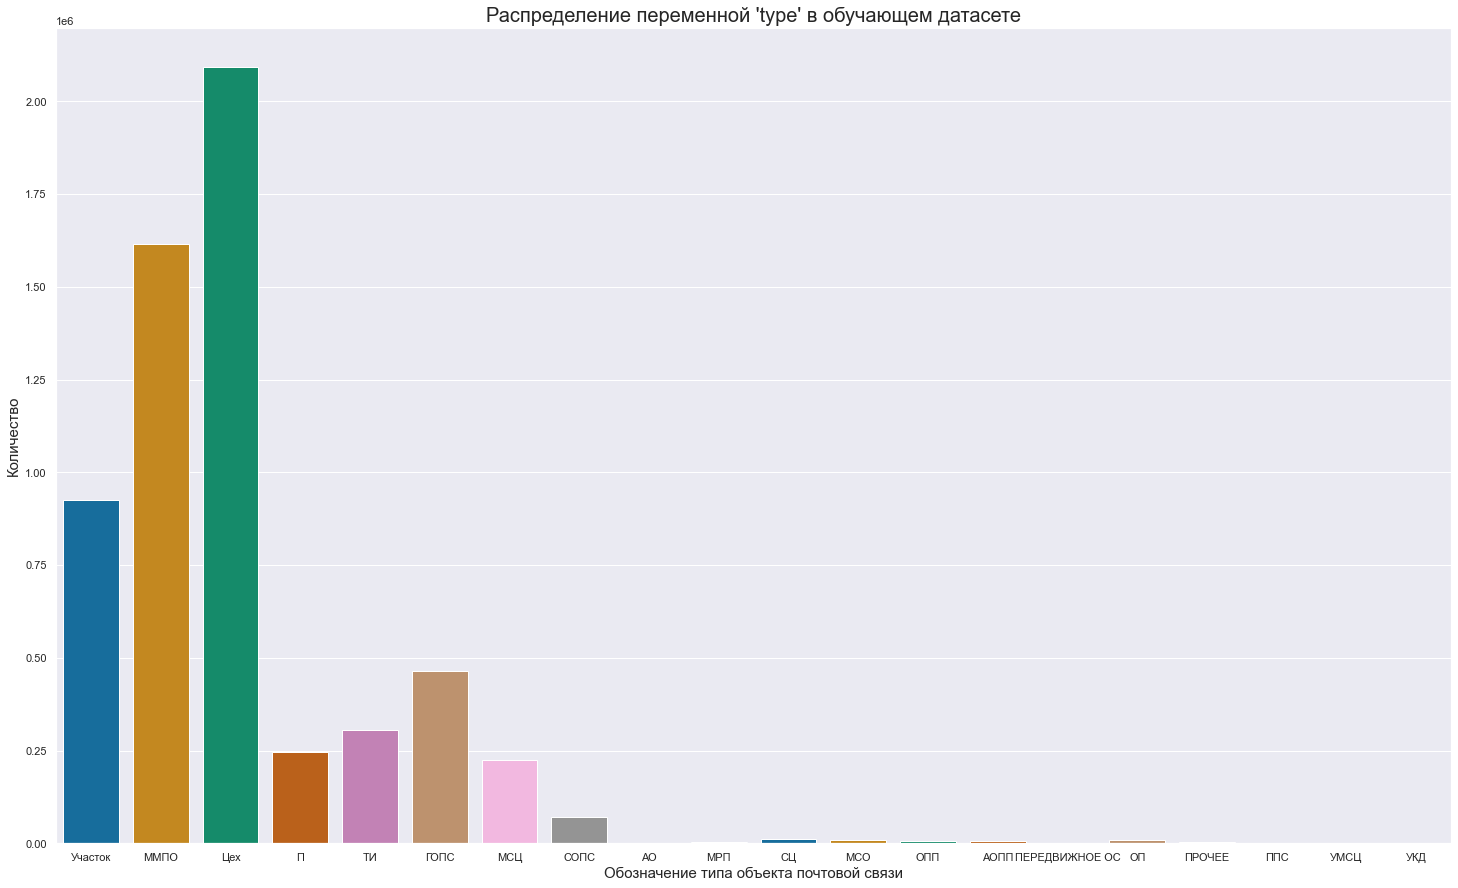

In [15]:
sns.set(rc={'figure.figsize':(25, 15)})
sns.set_style('darkgrid')

plot = sns.countplot(x='type', data=data_train, palette='colorblind')
plot.set_xlabel("Обозначение типа объекта почтовой связи", fontsize=15)
plot.set_ylabel("Количество", fontsize=15)
plot.set_title("Распределение переменной 'type' в обучающем датасете", fontsize=20)
plt.show();

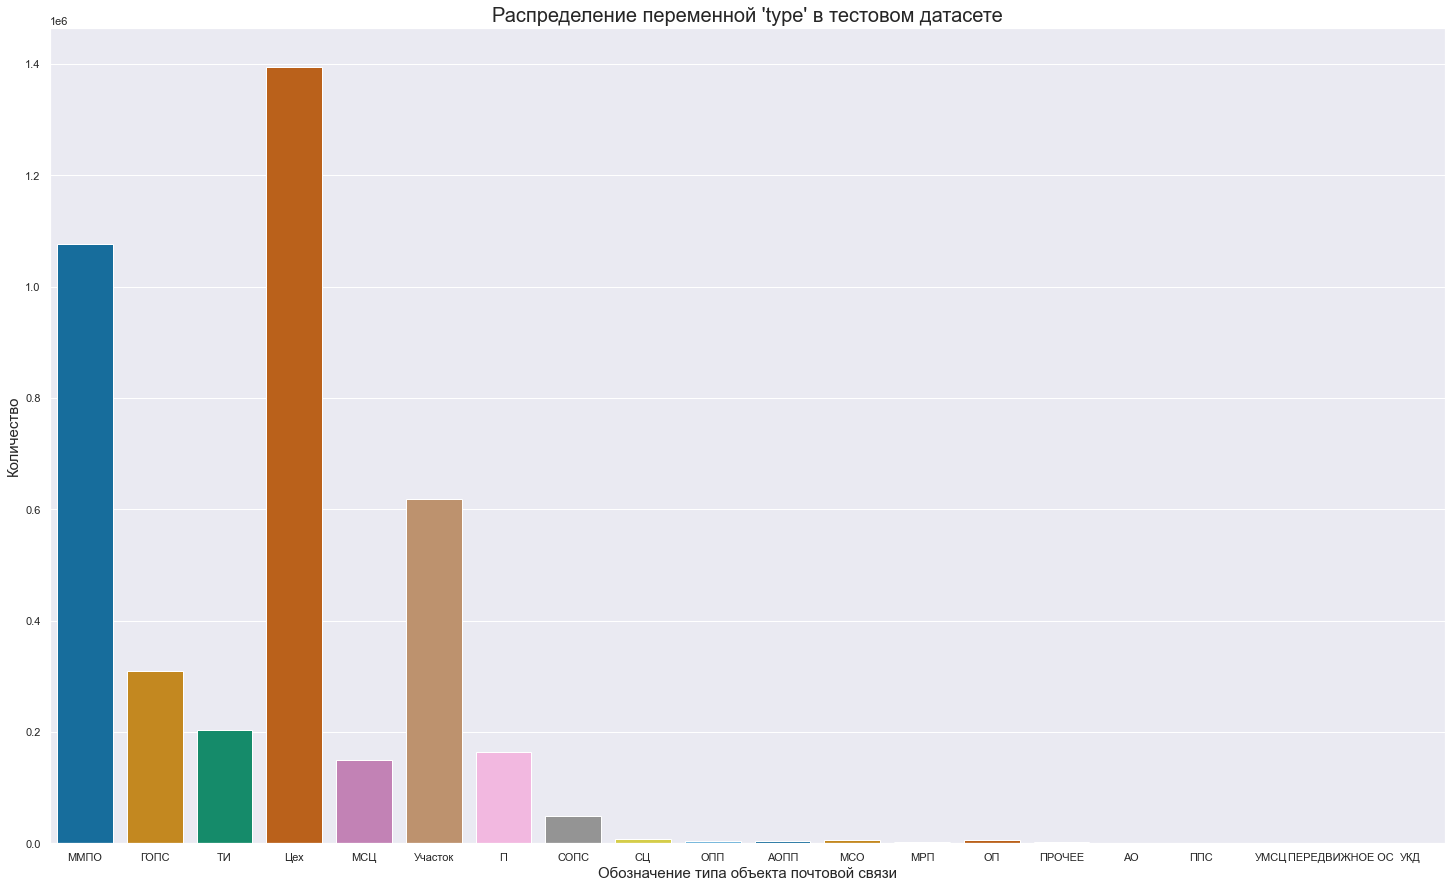

In [16]:
sns.set(rc={'figure.figsize':(25, 15)})
sns.set_style('darkgrid')

plot = sns.countplot(x='type', data=data_test, palette='colorblind')
plot.set_xlabel("Обозначение типа объекта почтовой связи", fontsize=15)
plot.set_ylabel("Количество", fontsize=15)
plot.set_title("Распределение переменной 'type' в тестовом датасете", fontsize=20)
plt.show();

##### *Значение класса или категории объекта почтовой связи*

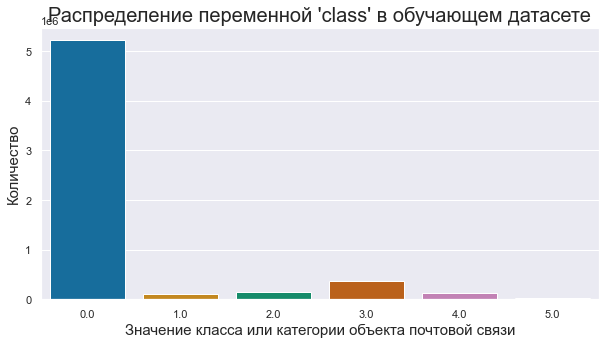

In [17]:
sns.set(rc={'figure.figsize':(10, 5)})
sns.set_style('darkgrid')

plot = sns.countplot(x='class', data=data_train, palette='colorblind')
plot.set_xlabel("Значение класса или категории объекта почтовой связи", fontsize=15)
plot.set_ylabel("Количество", fontsize=15)
plot.set_title("Распределение переменной 'class' в обучающем датасете", fontsize=20)
plt.show();

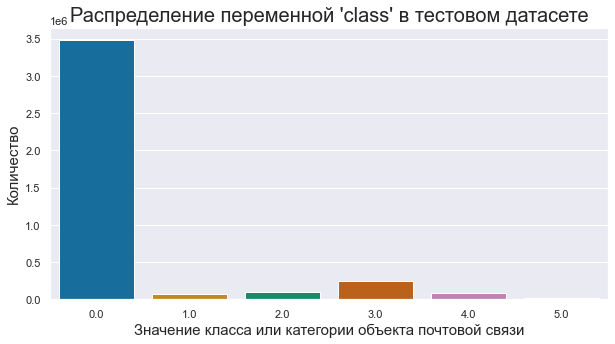

In [18]:
sns.set(rc={'figure.figsize':(10, 5)})
sns.set_style('darkgrid')

plot = sns.countplot(x='class', data=data_test, palette='colorblind')
plot.set_xlabel("Значение класса или категории объекта почтовой связи", fontsize=15)
plot.set_ylabel("Количество", fontsize=15)
plot.set_title("Распределение переменной 'class' в тестовом датасете", fontsize=20)
plt.show();

##### *Бинарные категориальные признаки*

##### Обучающая выборка

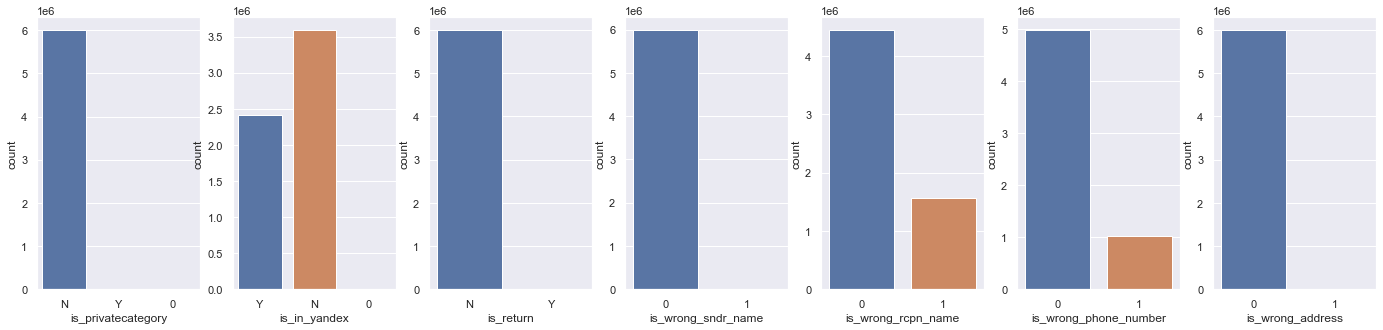

In [15]:
sns.set(rc={'figure.figsize':(24, 5)})
fig, ax = plt.subplots(1,7)

sns.countplot(data_train['is_privatecategory'], ax=ax[0])
sns.countplot(data_train['is_in_yandex'], ax=ax[1])
sns.countplot(data_train['is_return'], ax=ax[2])
sns.countplot(data_train['is_wrong_sndr_name'], ax=ax[3])
sns.countplot(data_train['is_wrong_rcpn_name'], ax=ax[4])
sns.countplot(data_train['is_wrong_phone_number'], ax=ax[5])
sns.countplot(data_train['is_wrong_address'], ax=ax[6])

fig.show()

##### Тестовая выборка

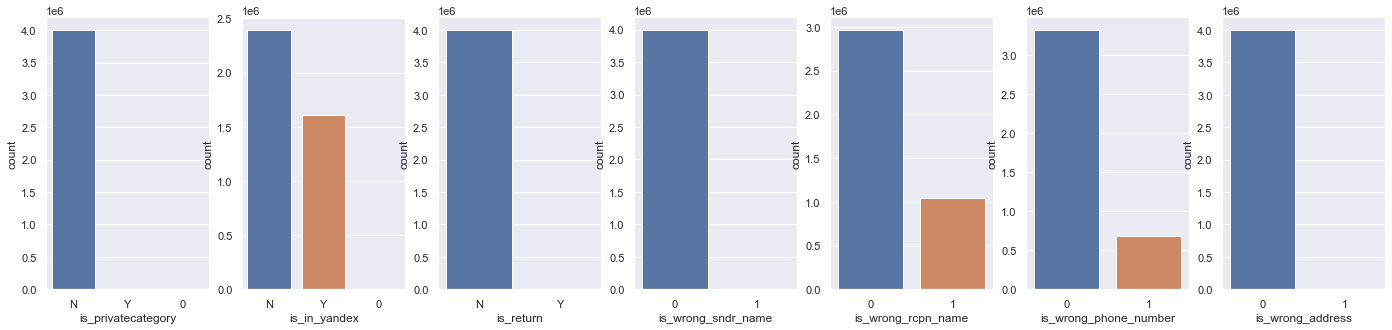

In [23]:
sns.set(rc={'figure.figsize':(24, 5)})
fig, ax = plt.subplots(1,7)

sns.countplot(data_test['is_privatecategory'], ax=ax[0])
sns.countplot(data_test['is_in_yandex'], ax=ax[1])
sns.countplot(data_test['is_return'], ax=ax[2])
sns.countplot(data_test['is_wrong_sndr_name'], ax=ax[3])
sns.countplot(data_test['is_wrong_rcpn_name'], ax=ax[4])
sns.countplot(data_test['is_wrong_phone_number'], ax=ax[5])
sns.countplot(data_test['is_wrong_address'], ax=ax[6])

fig.show()

##### *Текстовая информация*

In [24]:
data_train['name_mfi']

0                                          Fishhook,USB
1          screen protector,Case(Q613B),case(208B40-DB)
2           Pendant Necklaces,Rings for Women,Necklaces
3                                Motorcycle Signal Lamp
4                                              backpack
                               ...                     
5999995                                       KEY CHAIN
5999996                                           Dolls
5999997                                     Down jacket
5999998                                               0
5999999                Jewelry Beads,Jewelry Components
Name: name_mfi, Length: 6000000, dtype: object

In [25]:
data_train['name_mfi'] = np.where(data_train['name_mfi'] == '0', "Missing", data_train['name_mfi'])
data_test['name_mfi'] = np.where(data_test['name_mfi'] == '0', "Missing", data_test['name_mfi'])

In [26]:
data_train['name_mfi'].value_counts().count(), data_test['name_mfi'].value_counts().count()

(212936, 205458)

In [27]:
data_train['name_mfi'].value_counts()

Missing                                                                     815434
Mobile Phone Bags & Cases                                                    48165
Screen Protectors                                                            45032
phone case                                                                   42696
Phone Case                                                                   25031
                                                                             ...  
BRUSH(X-DZS-2inch)                                                               1
car led light(b-ty-highlander-15/18)                                             1
iPhone glass(1005001915468400)                                                   1
Tops,Women_s Jacket/T shirt,Women's Jacket/T shirt                               1
Piston Rings PR-PW60-2SET(PR-PW60-2SET),Piston Rings PR-PW60-2SET(PR-PW6         1
Name: name_mfi, Length: 212936, dtype: int64

In [28]:
data_test['name_mfi'].value_counts()

Missing                                                544856
Mobile Phone Bags & Cases                               32122
Screen Protectors                                       30108
phone case                                              28389
Phone Case                                              16613
                                                        ...  
Replacement Part(h42-20)                                    1
GY=Nail Stamping YZW-L007,GY=Nail Stamping YZW-L009         1
copper light string                                         1
Ear Piercing,Drop Earrings                                  1
phone case(YS001-i11-A-)                                    1
Name: name_mfi, Length: 205458, dtype: int64

##### *Корреляция переменных*

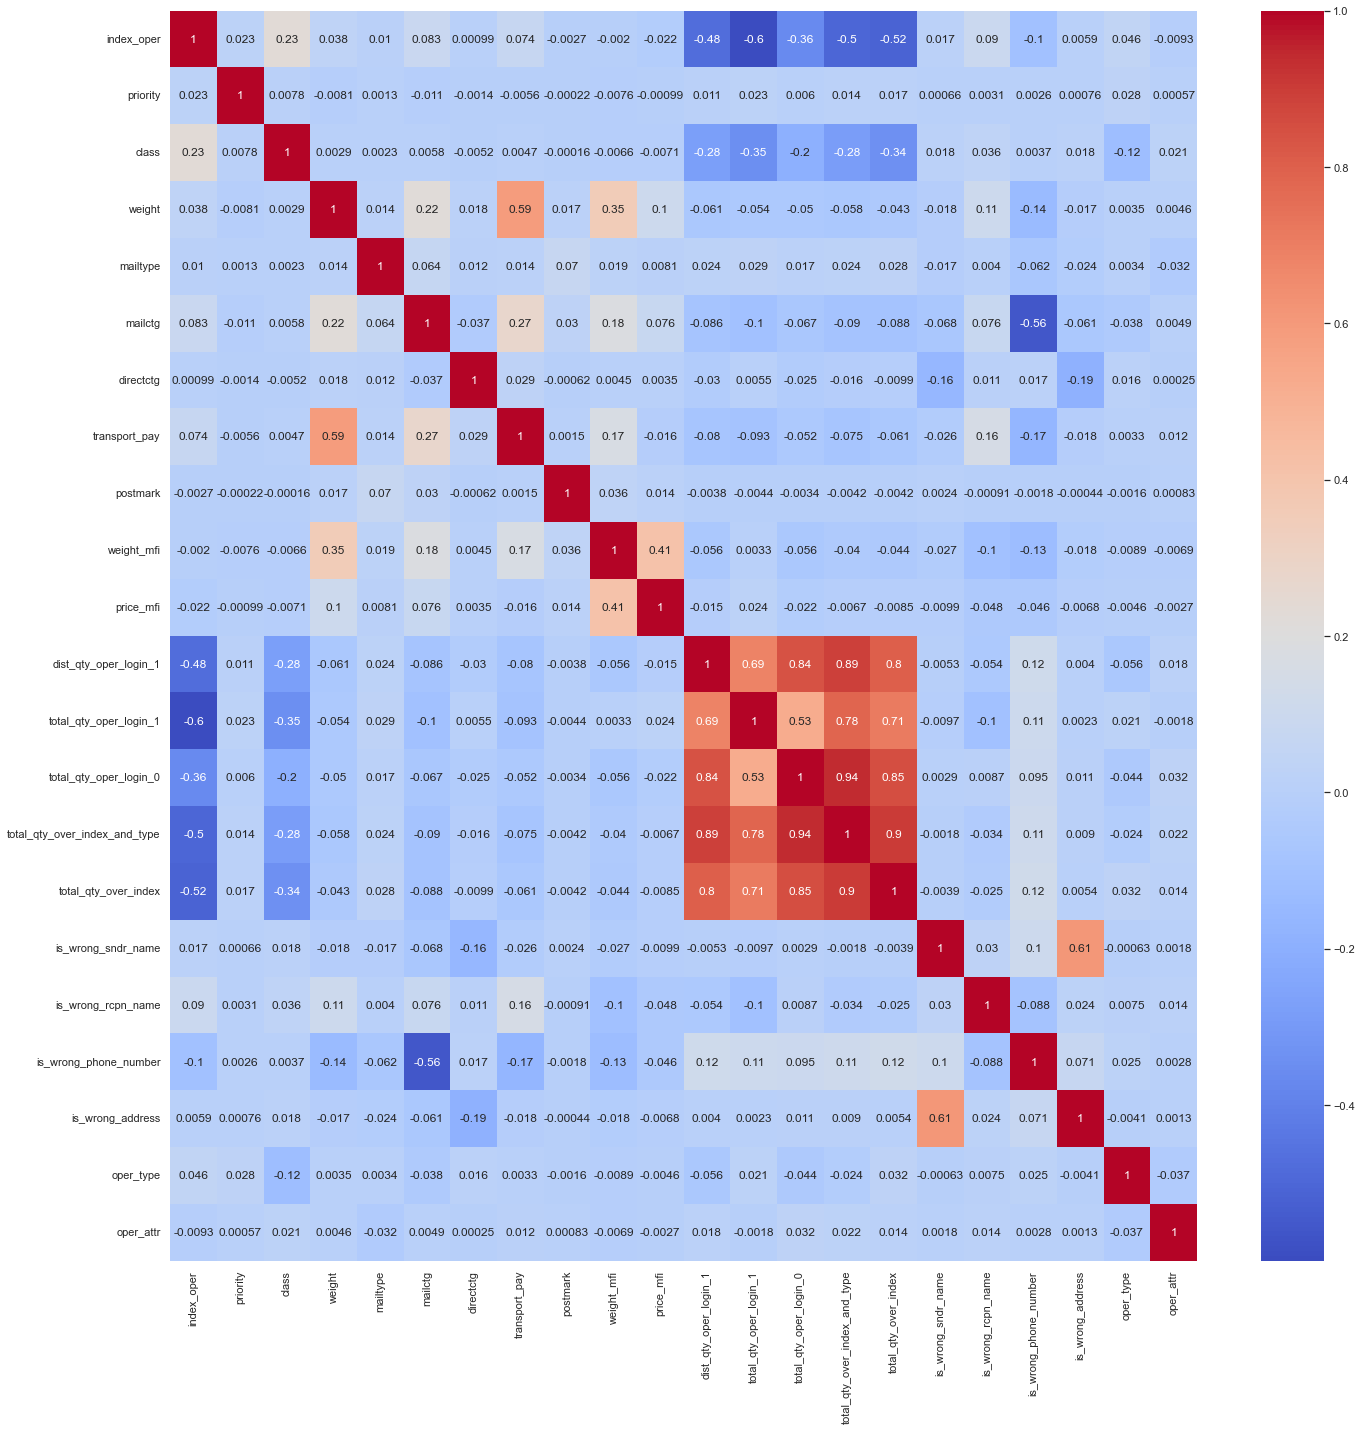

In [29]:
sns.set(rc={'figure.figsize':(23, 23)})
sns.heatmap(data_train.drop(['id','label','mailrank'], axis=1).corr(), cmap='coolwarm', annot=True);

In [30]:
data_train = data_train.drop(['id', 'mailrank'], axis=1)
data_test = data_test.drop(['id', 'mailrank'], axis=1)

In [31]:
data_train["type"] = pd.Categorical(data_train["type"])
data_train["type"].astype('category').cat.codes
data_train["type"] = data_train["type"].cat.codes

data_test["type"] = pd.Categorical(data_test["type"])
data_test["type"].astype('category').cat.codes
data_test["type"] = data_test["type"].cat.codes

In [32]:
data_train['is_privatecategory'] = data_train['is_privatecategory'].map({'Y': 1, 'N': 0, '0': -1}).astype(int)
data_train['is_in_yandex'] = data_train['is_in_yandex'].map({'Y': 1, 'N': 0, '0': -1}).astype(int)
data_train['is_return'] = data_train['is_return'].map({'Y': 1, 'N': 0, '0': -1}).astype(int)

data_test['is_privatecategory'] = data_test['is_privatecategory'].map({'Y': 1, 'N': 0, '0': -1}).astype(int)
data_test['is_in_yandex'] = data_test['is_in_yandex'].map({'Y': 1, 'N': 0, '0': -1}).astype(int)
data_test['is_return'] = data_test['is_return'].map({'Y': 1, 'N': 0, '0': -1}).astype(int)

In [33]:
data_train['priority'] = data_train['priority'].astype(int)
data_train['class'] = data_train['class'].astype(int)
data_train['postmark'] = data_train['postmark'].astype(int)
data_train['directctg'] = data_train['directctg'].astype(int)
data_train['mailctg'] = data_train['mailctg'].astype(int)
data_train['mailtype'] = data_train['mailtype'].astype(int)

data_test['priority'] = data_test['priority'].astype(int)
data_test['class'] = data_test['class'].astype(int)
data_test['mailctg'] = data_test['mailctg'].astype(int)
data_test['directctg'] = data_test['directctg'].astype(int)
data_test['postmark'] = data_test['postmark'].astype(int)
data_test['mailtype'] = data_test['mailtype'].astype(int)

In [34]:
data_train.shape, data_test.shape

((6000000, 28), (4000000, 27))

In [37]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(data_train.drop('label', axis=1), data_train['label'])

In [38]:
data_train_preprocessed = X_resampled.join(y_resampled)

In [40]:
data_train_preprocessed.shape

(11658040, 28)

### Сохранение обработанных выборок

In [42]:
data_train_preprocessed.to_csv("content/data_train_preprocessed.csv", line_terminator='\n')

In [43]:
data_test.to_csv("content/data_test_preprocessed.csv", line_terminator='\n')